In [1]:
import json
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt


In [2]:
# Inputs
paddle_file = '/kaggle/input/01-paddle-detector/results/boxes.json'
trocr_file = '/kaggle/input/02-trocr-detector/trocr_results/trocr_results.csv'
image_folder = Path('/kaggle/input/ocr-testing-images')

# Outputs
output_folder = Path('/kaggle/working/ocr_combined/')
output_folder.mkdir(exist_ok=True)


In [3]:
# PaddleOCR
with open(paddle_file, 'r') as f:
    paddle_data = json.load(f)

# TrOCR
trocr_data = pd.read_csv(trocr_file)


In [4]:
def normalize_bbox(bbox, width=1000, height=1000):
    if len(bbox) != 4:
        return [0, 0, width, height]
    return [int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])]


In [5]:
blocks = []

# PaddleOCR
for item in paddle_data:
    img_name = item['image_filename']
    bbox = normalize_bbox(item['bbox'])
    text = item.get('paddle_text','')
    blocks.append({
        'source':'paddle',
        'text': text,
        'bbox': bbox,
        'image_filename': img_name
    })

# TrOCR
for idx, row in trocr_data.iterrows():
    img_name = row.get('image_filename', paddle_data[0]['image_filename'])
    text = row.get('text','')
    
    # Approximate bbox using PaddleOCR box positions
    # Option 1: Take first PaddleOCR box in the same image
    paddle_boxes = [b for b in paddle_data if b['image_filename']==img_name]
    if paddle_boxes:
        ref_bbox = normalize_bbox(paddle_boxes[0]['bbox'])
        # Place TrOCR box inside top-left quarter of the PaddleOCR box
        x0,y0,x1,y1 = ref_bbox
        width = (x1-x0)//2
        height = (y1-y0)//2
        bbox = [x0, y0, x0+width, y0+height]
    else:
        bbox = [50,50,300,100]  # fallback
    
    blocks.append({
        'source':'trocr',
        'text': text,
        'bbox': bbox,
        'image_filename': img_name
    })


In [6]:
with open(output_folder/'blocks.json', 'w') as f:
    json.dump(blocks, f, indent=2)

pd.DataFrame(blocks).to_csv(output_folder/'blocks.csv', index=False)


In [7]:
def visualize_image(img_name, blocks, image_folder):
    page_blocks = [b for b in blocks if b['image_filename'] == img_name]
    img_path = list(image_folder.glob(img_name))
    if img_path:
        img = Image.open(img_path[0]).convert('RGB')
    else:
        img = Image.new('RGB', (1000,1000), 'white')
    
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    
    for b in page_blocks:
        x0,y0,x1,y1 = b['bbox']
        color = 'red' if b['source']=='paddle' else 'blue'
        draw.rectangle([x0,y0,x1,y1], outline=color, width=2)
        draw.text((x0, y0), b['text'][:30], fill=color, font=font)
    
    return img


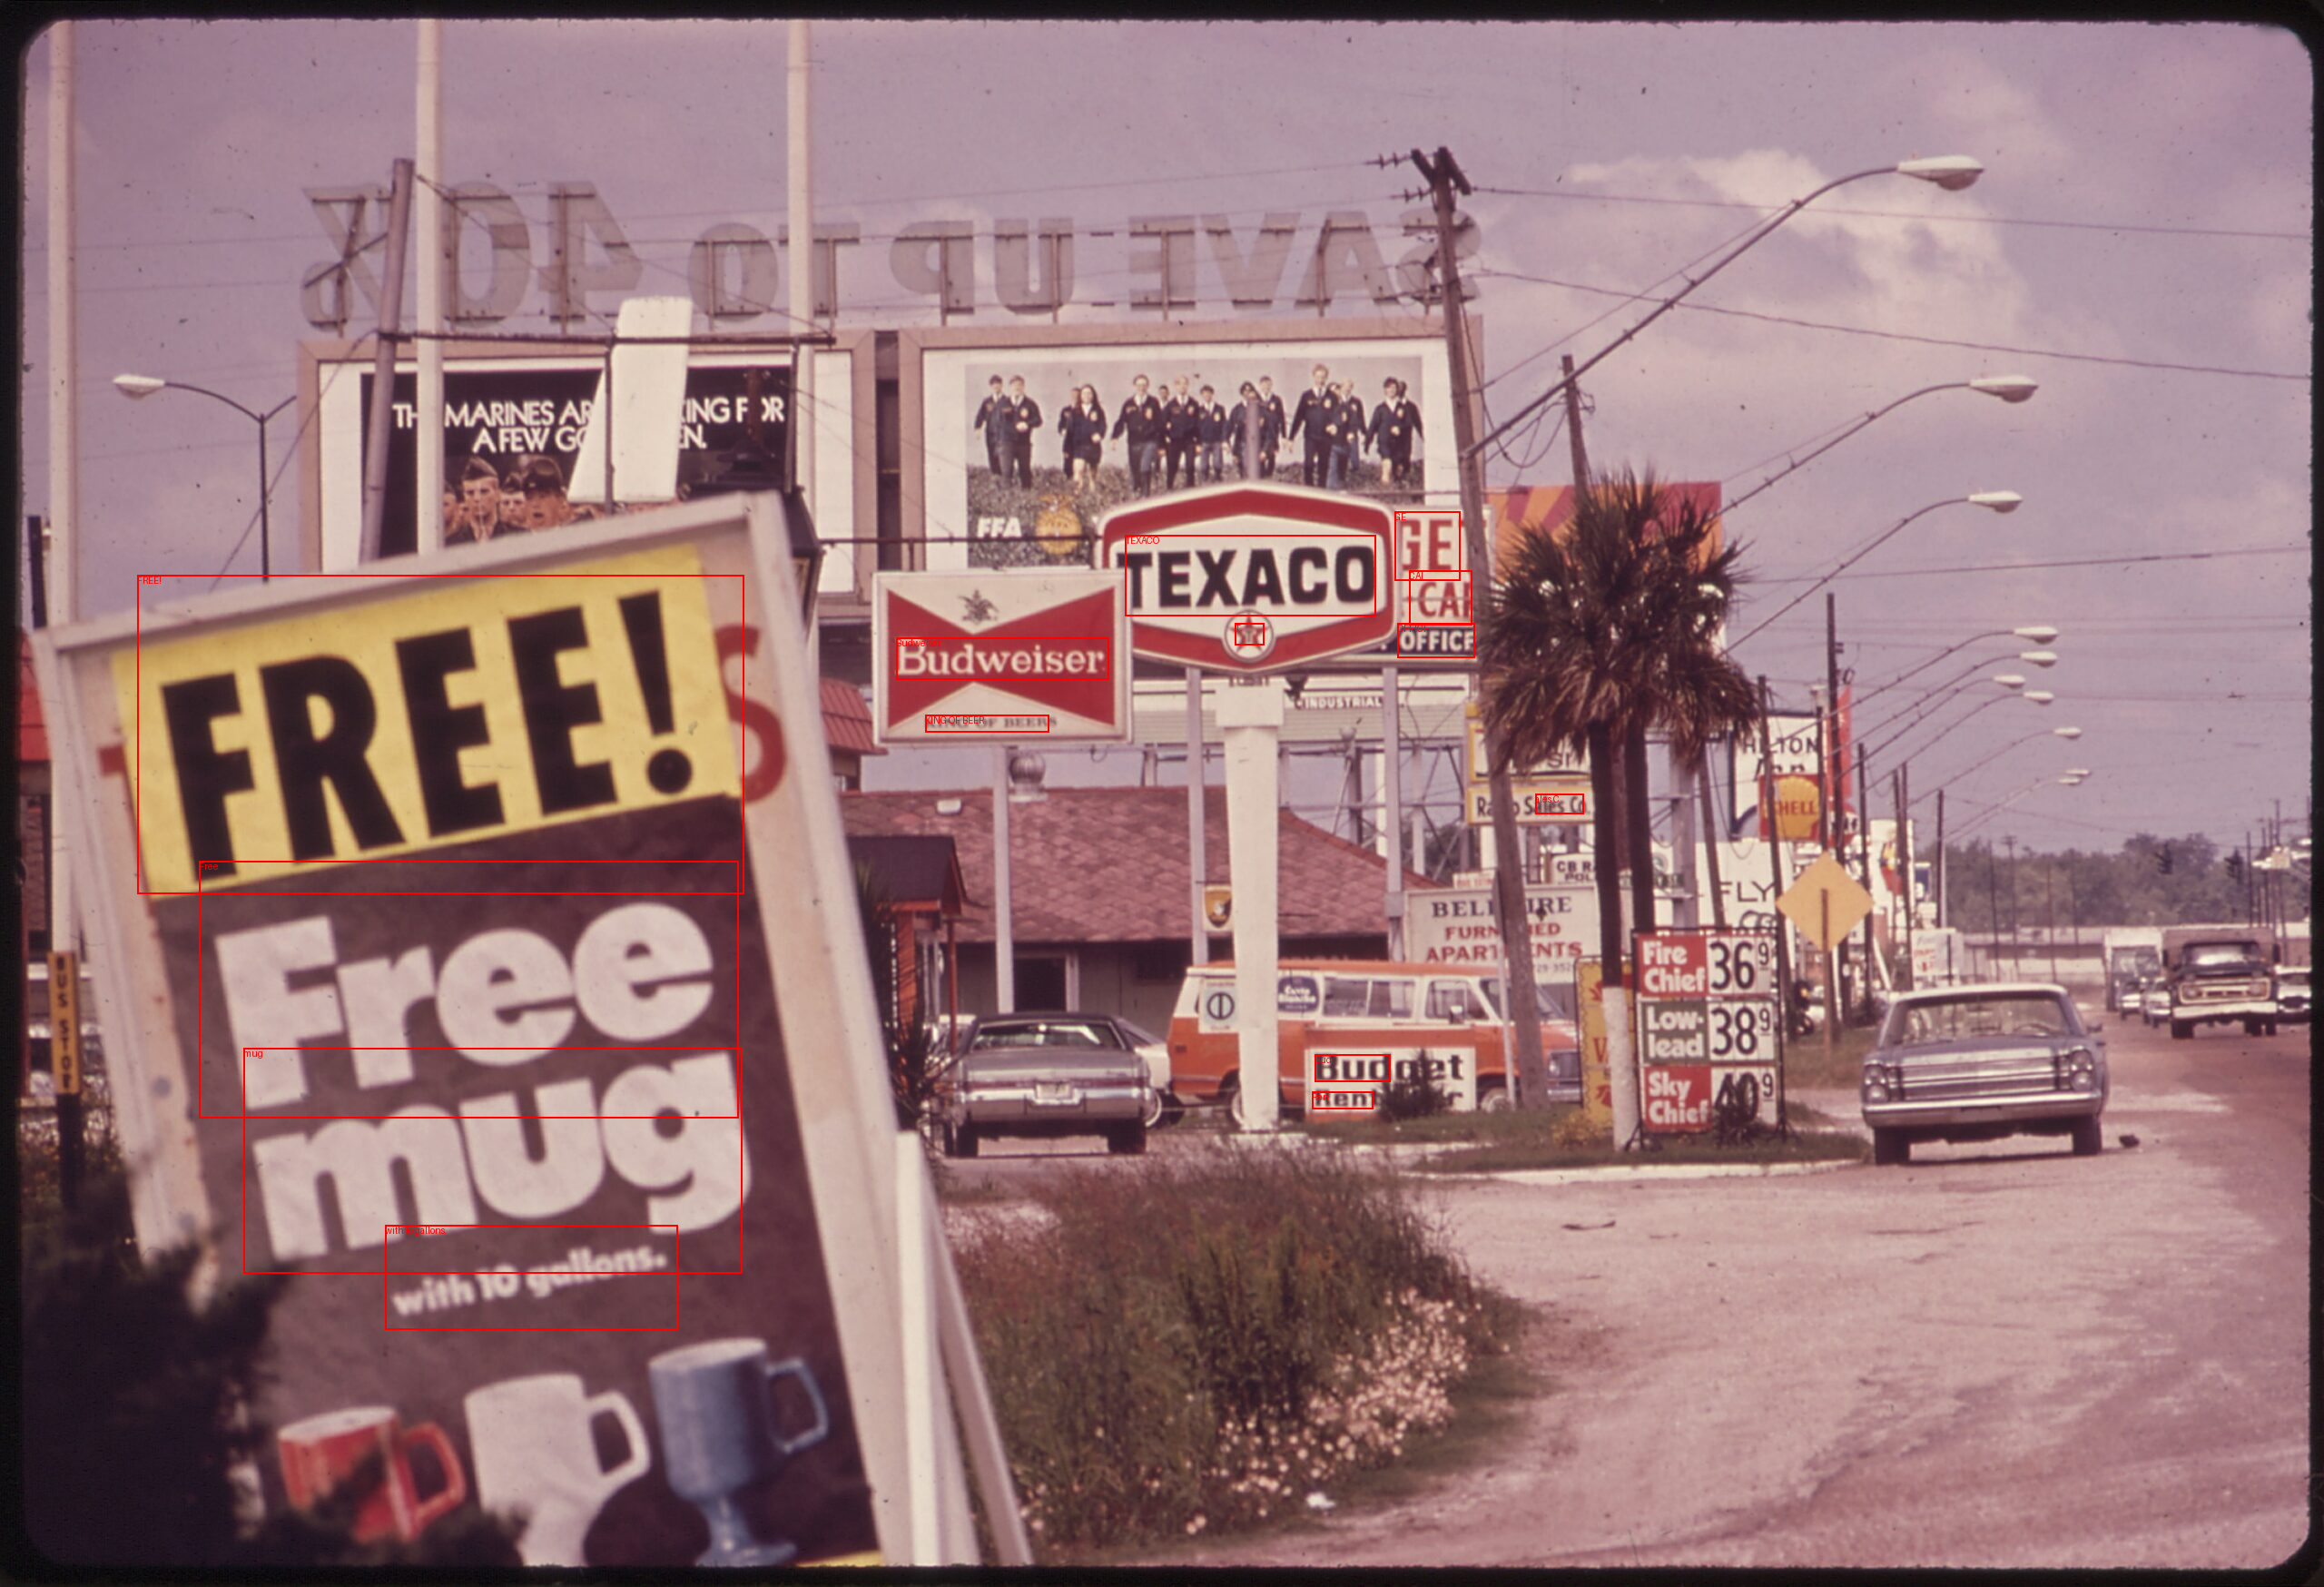

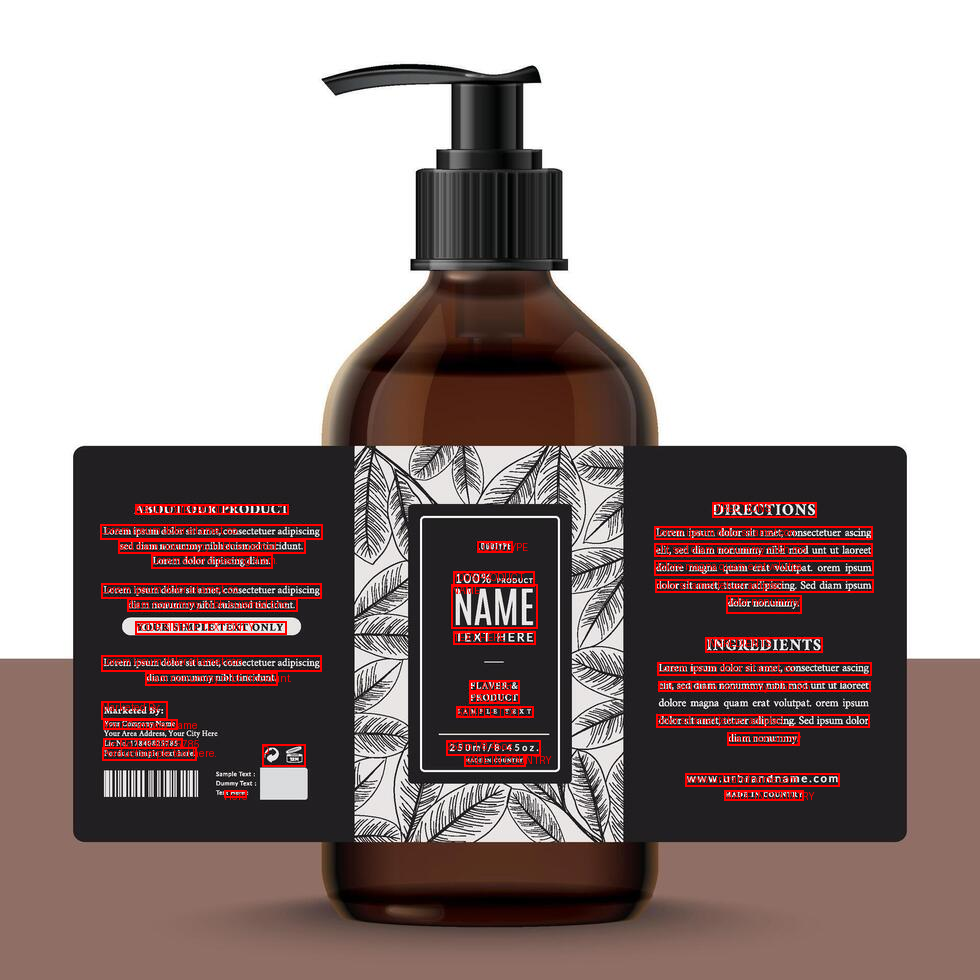

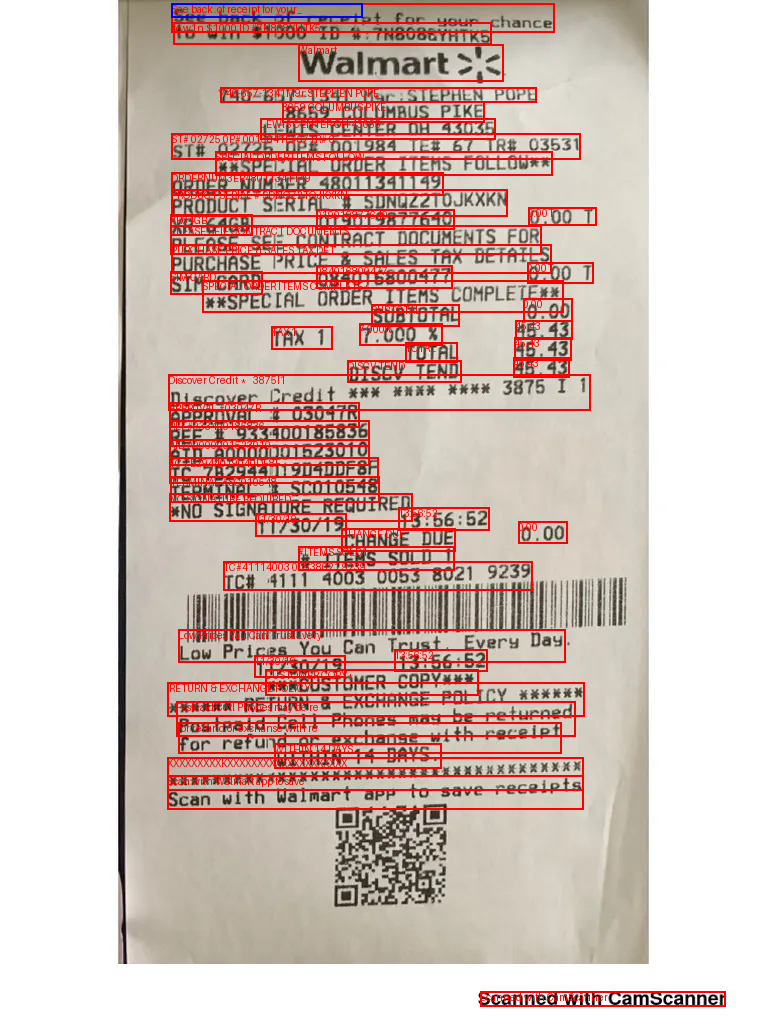

In [8]:
images = sorted(set(b['image_filename'] for b in blocks))
for img_name in images:
    img = visualize_image(img_name, blocks, image_folder)
    img.save(output_folder/f'heatmap_{img_name}')
    display(img)
